In [1]:
from functions.load_all_data import load_imgs_masks
from functions.sizes import compute_avg_size
from functions.composites import composite_masks
from skimage.transform import rescale, resize
import numpy as np
import matplotlib.pyplot as plt

# Rescale Masks
* select a sample mask to experiment with
* rescale and resize each work equally well, simply accept different parameters
* rescale accepts a ratio, resize accepts a new shape
* NOTE: rescale ratio affects both height AND width, so giving a ratio of 0.5 returns a composite that is .25 as large

In [2]:
all_imgs, mask_colls, paths = load_imgs_masks()

In [3]:
ex_imgs, ex_masks = all_imgs[:10], mask_colls[:10]

In [4]:
for i in range(len(ex_masks)):
    mask = ex_masks[i]
    ex_masks[i] = composite_masks(mask)

In [5]:
sample_img = ex_imgs[9]
sample_mask = ex_masks[9]

curr_size = compute_avg_size(sample_mask)
target_size = curr_size * 2

ratio = target_size / curr_size

In [6]:
rescaled = rescale(sample_mask, ratio, anti_aliasing=False, preserve_range=True, order=0)

2.0


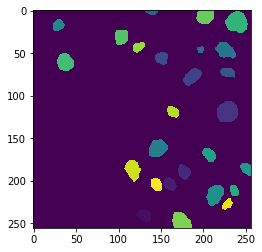

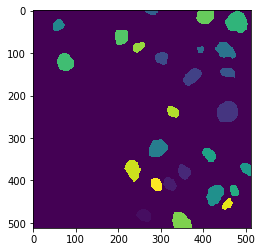

In [7]:
plt.imshow(sample_mask); plt.figure()
plt.imshow(rescaled)
print(ratio)

In [8]:
len(np.unique(rescaled))

27

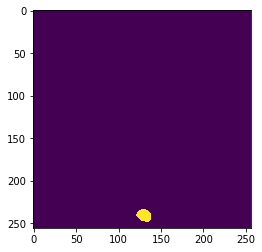

In [9]:
for color in np.unique(sample_mask):
    if color != 0:
        plt.imshow(sample_mask == color)
        break

# Experiment with decomposition for rescaling
* created technique for decomposing composite of masks
* each mask is rescaled individually and then the rescaled masks are made into a new composite
* both techniques (rescaling and decomposition) return desirable results

In [10]:
from functions.composites import decompose_composite
decomp_coll = decompose_composite(sample_mask)

In [11]:
new_shape = (sample_mask.shape[0] * ratio, sample_mask.shape[1] * ratio)
for i in range(len(decomp_coll)):
    mask = resize(decomp_coll[i], new_shape, anti_aliasing=False, preserve_range=True, order=0)
    decomp_coll[i] = mask

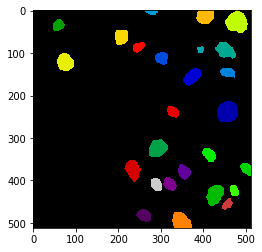

In [12]:
new_comp = composite_masks(decomp_coll)
plt.imshow(new_comp, cmap='nipy_spectral')

In [13]:
print("Original size = %f\nRescaled size = %f\nNew Comp. size = %f" 
     %(compute_avg_size(sample_mask), compute_avg_size(rescaled), compute_avg_size(new_comp)))

Original size = 236.038462
Rescaled size = 944.153846
New Comp. size = 944.153846


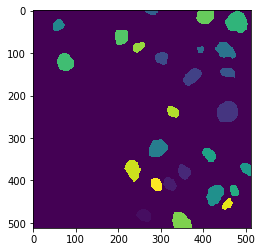

In [14]:
plt.imshow(rescaled)

In [15]:
assert int(compute_avg_size(sample_mask) * (ratio ** 2)) == int(compute_avg_size(new_comp))

# Confirm Numerically
* assert that rescaling works for different ratios and mask compositions

In [16]:
for i in range(670):
    curr_mask = composite_masks(mask_colls[i])
    curr_size = compute_avg_size(curr_mask)
    
    rand_val = np.random.uniform() * 3
    target_size = curr_size * rand_val
    
    rand_ratio = target_size / curr_size
    rand_ratio = rand_ratio ** (1/2)
    
    expected_target = int(curr_size * (rand_ratio ** 2))
    
    rand_shape = (int(curr_mask.shape[0] * rand_ratio),
                  int(curr_mask.shape[1] * rand_ratio))
    
    resized_mask = resize(curr_mask, rand_shape, anti_aliasing=False, preserve_range=True, order=0)
    resized_size = compute_avg_size(resized_mask)
    diff = abs(int(expected_target - resized_size))
    
    if expected_target > 1000:
        error = curr_size * .02
    else:
        error = 20
        
    assert diff <= error, "Mask: %d, Ratio: %f, Difference: %f\n\t\tOriginal size: %f Target size: %f, Rescaled size: %f" %(i, rand_ratio, diff, curr_size, expected_target, resized_size)

print("All good!")

All good!


# Rescale Images

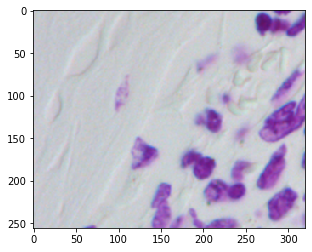

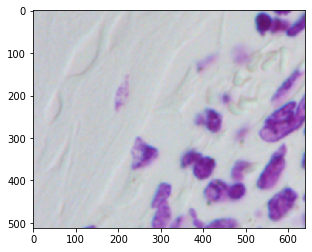

In [17]:
resized_img = resize(all_imgs[200], 
                      (all_imgs[200].shape[0] * ratio, 
                       all_imgs[200].shape[1] * ratio),
                      anti_aliasing=True, preserve_range=False)
plt.imshow(all_imgs[200]); plt.figure()
plt.imshow(resized_img)

In [19]:
from functions.rescaling import rescale_img_comp

Original size: 236.038462, Rescaled size: 797.192308


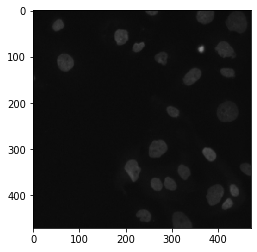

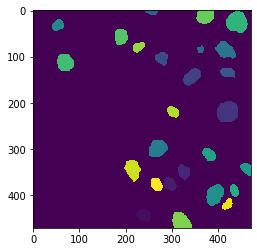

In [21]:
rescaled_img, rescaled_comp = rescale_img_comp(sample_img, sample_mask, 800, True)

# Create Training Dataset
1. Compute the distribution of sizes in the training set. This can be histogram of average sizes in all images with 100 bins, for instance.
2. For each bin in the distribution, take 200 random images and rescale them to match the size of the bin. For instance, a hypothetical distribution of sizes with 3 bins may have objects of 100, 200, and 300 pixels of area. For each bin, sample 200 images at random and rescale them with target size 100, 200, and 300 respectively.
3. Using 100 bins, this will give you 20,000 examples for training. Prepare the images and the labels (size) for training the neural net
4. Make a random crop of the rescaled image b.c the network will only accept images of the same shape
* ex) 128x128

_After creating training dataset, normalize nuclei sizes_
* find the mean of all the values and divide by std. dev
* with mean and std. dev (x= (x-mean)/ std. dev) --> normalized nuclei sizes
* use np to find both
* We want the prediction to be within the same bin; if it changes bins then that is unacceptable
* The tolerance will be the average distance between the bins in the histogram

In [22]:
nuclei_sizes = []
mask_comps = []
for collection in mask_colls:
    curr_mask = composite_masks(collection)
    curr_size = compute_avg_size(curr_mask)
    
    mask_comps.append(curr_mask)
    nuclei_sizes.append(curr_size)

[ 73. 147.  93.  56.  37.  43.   9.  18.  27.   4.   5.   3.   8.   5.
   5.   9.   6.  11.   7.   9.  18.  13.  21.   7.   8.   9.   6.   4.
   3.   1.   0.   1.   2.   0.   0.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.] 
 [  26.           98.18071429  170.36142857  242.54214286  314.72285714
  386.90357143  459.08428571  531.265       603.44571429  675.62642857
  747.80714286  819.98785714  892.16857143  964.34928571 1036.53
 1108.71071429 1180.89142857 1253.07214286 1325.25285714 1397.43357143
 1469.61428571 1541.795      1613.97571429 1686.15642857 1758.33714286
 1830.51785714 1902.69857143 1974.87928571 2047.06       2119.24071429
 2191.42142857 2263.60214286 2335.78285714 2407.96357143 2480.1442857

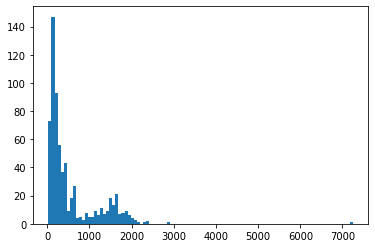

In [23]:
n, bins, patches = plt.hist(nuclei_sizes, bins=100)
print(n,"\n", bins)

In [24]:
sizes_comps_imgs = sorted(zip(nuclei_sizes, mask_comps, all_imgs), key = lambda x:x[0])

In [39]:
resized_triads = []
for i in range(100):
    if n[i] != 0.:
        target_size = bins[i]
        if i+1 < 100:
            curr_triads = [triad for triad in sizes_comps_imgs if (triad[0] >= bins[i]) and triad[0] < bins[i+1]]
        else:
            curr_triads = [triad for triad in sizes_comps_imgs if triad[0] >= bins[i]]
        
        for (size, comp, img) in curr_triads:
            resized_img, resized_comp = rescale_img_comp(img, comp, target_size)
            resized_triads.append((target_size, resized_comp, resized_img))

25.917333333333332

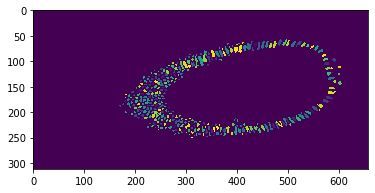

In [42]:
plt.imshow(resized_triads[71][1])
compute_avg_size(resized_triads[71][1])

96.936

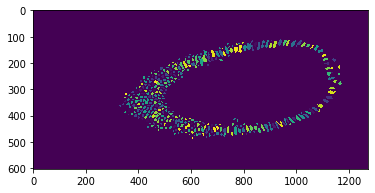

In [31]:
plt.imshow(sizes_comps_imgs[71][1])
compute_avg_size(sizes_comps_imgs[71][1])